In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

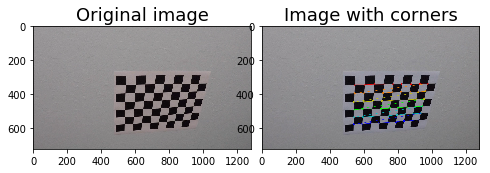

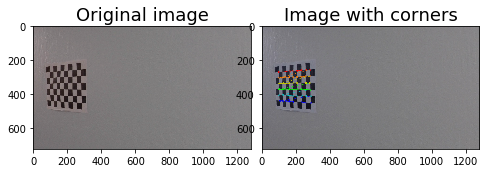

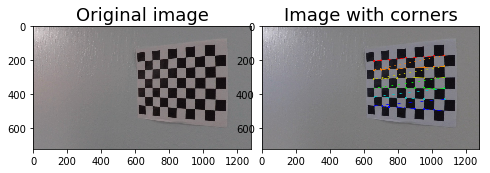

In [2]:
nx = 9
ny = 6
objectpoints = []
imagepoints = []

#Generate object points like (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Search for chessboard corners
i = 0
for fname in glob.glob("camera_cal/calibration*.jpg"):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Convert to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    i = i + 1
    # Draw and display the corners
    if (i < 5):
        if ret is True:
            imagepoints.append(corners)
            objectpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
            f.subplots_adjust(hspace = .2, wspace=.05)
            ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Image with corners', fontsize=18)
            plt.show()

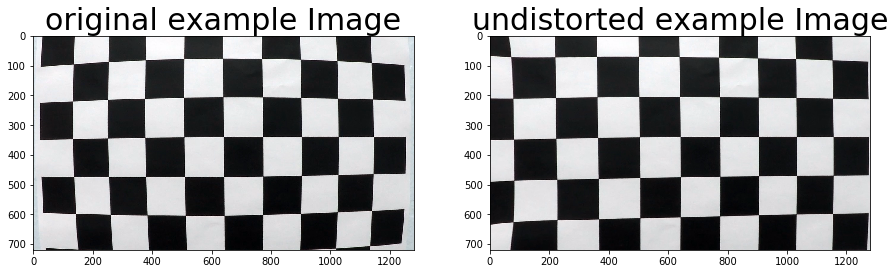

In [3]:
# Undistort plot on an example image
img = cv2.imread(os.path.join('camera_cal', 'calibration1.jpg'))
# Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, gray.shape[::-1], None, None)
# Undistorting
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(img)
ax1.set_title('original example Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('undistorted example Image', fontsize=30)
plt.show()

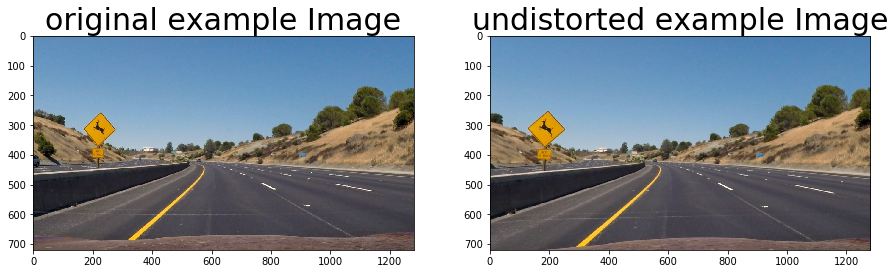

In [20]:
#  An example of a distortion corrected image
image = cv2.imread(os.path.join('test_images', 'test2.jpg'))
imshape = image.shape
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(image)
ax1.set_title('original example Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted example Image', fontsize=30)
plt.show()

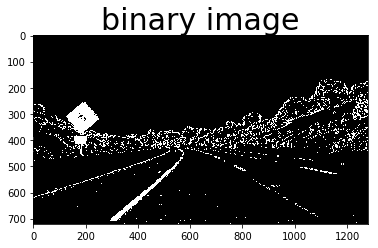

In [21]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
plt.imshow(combined_binary, cmap='gray')
plt.title('binary image', fontsize=30)
plt.show()

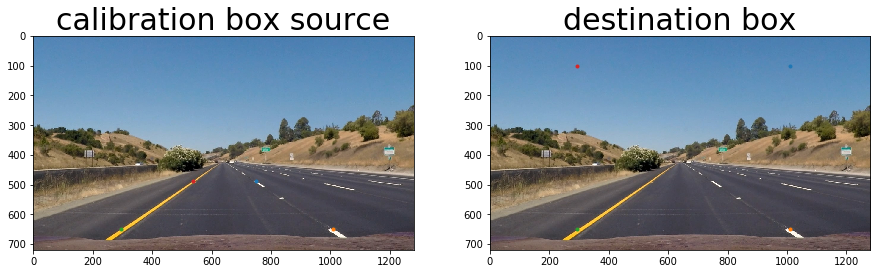

In [22]:
# Code to choose 4 Points in an interative window
import matplotlib.image as mpimage
%matplotlib inline

imagee = mpimage.imread(os.path.join('test_images', 'straight_lines1.jpg'))

# Define perpective transform function
def warp(img):
    #Define calibration box in source(original) and destination(desired or warped) coordinates
    src = np.float32([[750, 488],[1010, 650],[294, 650], [539, 488]])
    dst = np.float32([[1010, 488], [1010, 650],[294, 650], [294, 488]])

    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(src, dst)
    # Warp an image using the perspective transform, M
    binary_warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return binary_warped

binary_warped = warp(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(imagee)
ax1.set_title('calibration box source', fontsize=30)
ax1.plot(750, 488, '.') #top right
ax1.plot(1010, 650, '.') #bottom right
ax1.plot(294, 650, '.') #bottom left
ax1.plot(539, 488, '.') #top left

ax2.imshow(imagee)
ax2.set_title('destination box', fontsize=30)
ax2.plot(1010, 100, '.') #top right
ax2.plot(1010, 650, '.') #bottom right
ax2.plot(294, 650, '.') #bottom left
ax2.plot(294, 100, '.') #top left
plt.show()

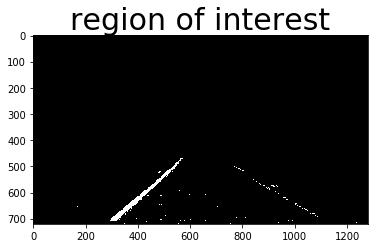

In [23]:
imshape = img.shape
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")
plt.title('region of interest', fontsize=30)
plt.show()

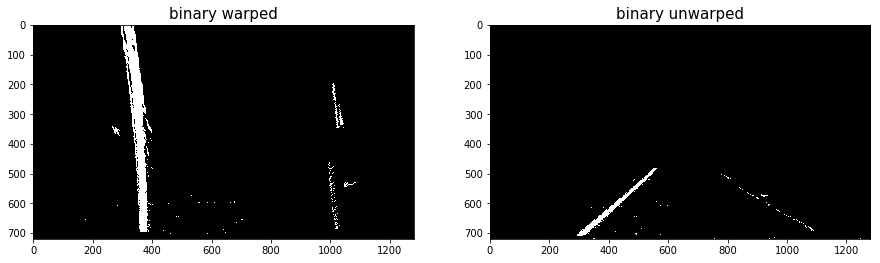

In [24]:

#src = np.float32([[490, 482],[810, 482],[1250, 720], [40, 720]])
#dst = np.float32([[0, 0], [1280, 0],[1250, 720], [40, 720]])

src = np.float32([[750, 488],[1010, 650],[294, 650], [539, 488]])
dst = np.float32([[1010, 100], [1010, 650],[294, 650], [294, 100]])
# Compute the perspective transform, M, given source and destination points
M = cv2.getPerspectiveTransform(src, dst)
# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp an image using the perspective transform, M
binary_warped = cv2.warpPerspective(masked_image, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
binary_unwarped = cv2.warpPerspective(binary_warped, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.imshow(binary_warped, cmap="gray")
ax1.set_title('binary warped', fontsize=15)

ax2.imshow(binary_unwarped, cmap="gray")
ax2.set_title('binary unwarped', fontsize=15)
plt.show()



In [25]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

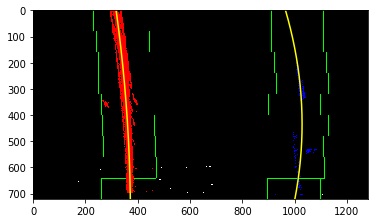

In [26]:
# visualize the result 
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [27]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = binary_warped.shape[0]
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius: ',left_curverad, 'm', right_curverad, 'm')

# Center offset = Middle of both lines to middle of the picture in m
left_line_bot = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_line_bot = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
mid_bot = (left_line_bot + right_line_bot) / 2
mid_photo = image.shape[1] / 2
off_center = (mid_bot - mid_photo) * xm_per_pix
offset_string = "Center offset: %.2f m" % off_center
print(offset_string)



Radius:  1870.91791185 m 489.823390611 m
Center offset: 0.25 m


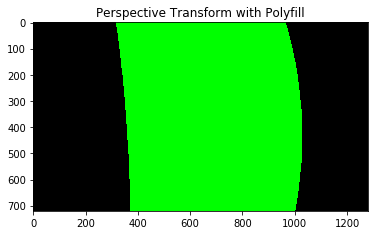

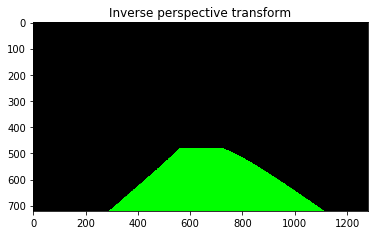

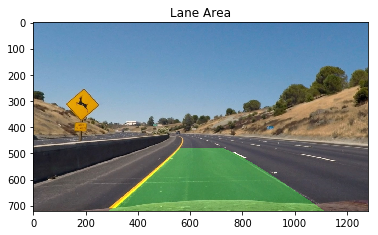

In [28]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8) 
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
plt.imshow(color_warp)
plt.title('Perspective Transform with Polyfill')
plt.show()

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(newwarp)
plt.title('Inverse perspective transform')
plt.show()

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.title('Lane Area')
plt.show()

# Video Pipeline

In [ ]:
## As seen in the forum, still not working
# Create an image to draw the lines on
warp_zero = np.zeros_like(image)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
newwarp = cv2.warpPerspective(warp_zero, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

# Helperfunctions 

In [119]:

imshape = img.shape

def get_binary_imagev2(img, s_thresh=(150, 255), sx_thresh=(40, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def get_binary_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def warp(img):
    #Define calibration box in source(original) and destination(desired or warped) coordinates
    src = np.float32([[750, 488],[1010, 650],[294, 650], [539, 488]])
    dst = np.float32([[1010, 100], [1010, 650],[294, 650], [294, 100]])

    # Compute the perspective transform, M, given source and destination points
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    binary_warped = cv2.warpPerspective(img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return binary_warped

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    print(mask)
    print(img)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def new_search(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_fit, right_fit

def followup_search(img):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_fit, right_fit

In [125]:
def pipeline(img):
    # storing the polynomial coefficients of previously found lines
    global prev_leftcoeffs
    global prev_rightcoeffs
    
    # store average line coordinates from previous n frames
    global past_good_rightlines
    global past_good_leftlines
    
    # Clear figure
    plt.clf()
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary = get_binary_image(undist)
    masked_image = region_of_interest(combined_binary)
    binary_warped = warp(masked_image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.imshow(binary_warped, cmap="gray")
    ax1.set_title('binary warped', fontsize=15)

    ax2.imshow(binary_warped, cmap="gray")
    ax2.set_title('binary unwarped', fontsize=15)
    plt.show()
    

    if(not prev_leftcoeffs) or (not prev_rightcoeffs):
        ploty, left_fitx, right_fitx, left_fit, right_fit = new_search(binary_warped)
        prev_leftcoeffs = left_fit
        prev_rightcoeffs = right_fit
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = followup_search(binary_warped)
        prev_leftcoeffs = left_fit
        prev_rightcoeffs = right_fit   
    
    return binary_warped

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


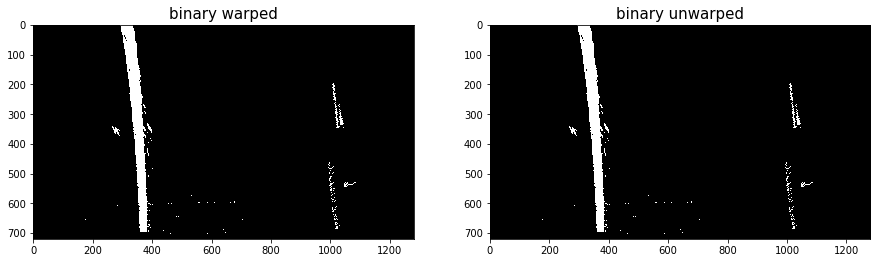

[ -8.77790033e-05   1.38526474e-01   3.17576802e+02]


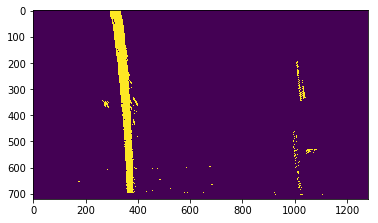

In [126]:
prev_leftcoeffs = []
prev_rightcoeffs = []
past_good_rightlines = []
past_good_leftlines = []

image = cv2.imread(os.path.join('test_images', 'test2.jpg'))
result = pipeline(image)
plt.imshow(result)
plt.show()

In [124]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_leftcoeffs = []
prev_rightcoeffs = []
past_good_rightlines = []
past_good_leftlines = []

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

OSError: [WinError 6] Das Handle ist ungültig